# Art Gallery Theory basics
This notebook accompanies chapter 11 of "Applied Math for Security". This chapter describes the foundation for the Art Gallery problem and examines the basic algorithm for solving. The code for the chapter listings as well as the code I used to generating the images for the chapter live in this notebook. See the chapter text for details on the algorithm itself.

The following cell imports all the necessary libraries and defines several helper functions which are used throughout the algorithm. 

In [1]:
import networkx as nx
from networkx.algorithms.coloring import greedy_color
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Point, LineString, MultiLineString
from shapely.geometry import Polygon, LinearRing, LineString, Point
from matplotlib import pyplot as plt
from colour import Color
import triangle as tr
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from math import cos, sin
import numpy as np

def get_endpoint(p, angle, length):
    """Convert angle and magnitude to end point"""
    x1, y1 = p
    return ((x1 + length*cos(angle), y1 + length*sin(angle)))

def create_fov_coords(pos, angle, fov, eff_range, div):
    """Create a set of points from a starting angle and a field of view"""
    offset = int(fov/2)
    view_points = [pos]
    start_angle = int(angle + offset)
    end_angle = int(angle - offset)
    step = int(-1 * (fov / div))
    angles = []
    for i in range(start_angle, end_angle, step):
        angles.append(i)
        end_p = get_endpoint(p, i, eff_range)
        view_points.append(end_p)
    last_p = get_endpoint(pos, angle - offset, eff_range)
    view_points.append(end_p)
    print(angles)
    return (view_points, angles)

def assign_triangles(graph, triangulated, group_id):
    """Assign a triangle segment to the closest guard from the given group"""
    guard_nodes = [n for n in graph.nodes() if graph.nodes[n]["group"] == group_id]
    triangles = {k:[] for k in guard_nodes}

    for i in range(len(triangulated["triangles"])):
        t = triangulated["triangles"][i]
        t_poly = Polygon([graph.nodes[p]["coords"] for p in t])

        # if triangle touches a guard directly at any point
        if t[0] in guard_nodes:
            triangles[t[0]].append(t_poly)
        elif t[1] in guard_nodes:
            triangles[t[1]].append(t_poly)
        elif t[2] in guard_nodes:
            triangles[t[2]].append(t_poly)
        else:
            dists = {
                k: t_poly.distance(Point(graph.nodes[k]["coords"])) for k in guard_nodes
            }
            close = min(dists, key=dists.get)
            #print("closest: %d" % close)
            triangles[close].append(t_poly)
    return triangles

def count_groups(colored_dict):
    """Count the number of groups present in the solution"""
    seen = []
    for k in list(colored_dict.keys()):
        if gallery_coloring[k] not in seen:
            seen.append(gallery_coloring[k])
    return(len(seen))

def group_symbol(group_i):
    """Return a symbol for plotting given a group ID
    currently 7 groups can be represented
    """
    sym_table = ['o','d','s','*',"P","X","D"]
    return sym_table[group_i]

def group_color(group_i):
    """Return a color for plotting given a group ID
    currently 7 groups can be represented
    """
    color_table = ['red','blue','green','orange','gray','purple', 'teal']
    return color_table[group_i]

## AGP Primer
The following code represents the simplest case of the algorithm in the book. The code creates a triangle gallery represented as a polygon. It then converts the polygon into a matching graph representation. Because the shape is already a triangle we don't need to include the step of tessellation for this example.

In [2]:
# Build the representation of the gallery as a polygon
gallery_poly = Polygon([(0, 0), (0, 2), (1, 1) ])
x, y = gallery_poly.exterior.xy
G = nx.Graph()
gallery_coords = gallery_poly.exterior.coords[0:-1]
G.add_node(0, coords= gallery_coords[0])
pos = [list(gallery_coords[0])]
# convert the polygon to a graph using the vertex's index as the node ID
for i in range(1,len(gallery_coords)):
    p = gallery_coords[i] 
    pcs = [p[0], p[1]]
    pos.append(pcs)
    G.add_edge(i-1, i)
    G.nodes[i]["coords"] = pcs
    # close the shape edges
    if i == len(gallery_coords)-1:
        G.add_edge(i, 0)
# You can define your own color ranges using the color library
red = Color("red")
blue = Color("blue")
color_list = list(red.range_to(blue, len(G.nodes())))

The code in the following cell performs the coloring solution part of the algorithm. It is important to remember to color the graph after you perform the tessellation under normal circumstances. once the coloring has be complete the graph representation is updated to hold the results as node attributes

In [3]:
# Perform the coloring
gallery_coloring = greedy_color(G)
# update the graph representation
for k in gallery_coloring.keys():
    v = gallery_coloring[k]
    G.nodes[k]["color"] = color_list[v].rgb
    G.nodes[k]["group"] = v
cgroups = [G.nodes[k]["group"] for k in G.nodes]

The next cell generates a three-column plot showing the simplest case for the algorithm which is a triangle. One great piece of information to keep in mind is that NetworkX is compatible with MatPlotLib. By passing an Axes object in the ax parameter you can tell Networkx to draw the graph on a specific subplot

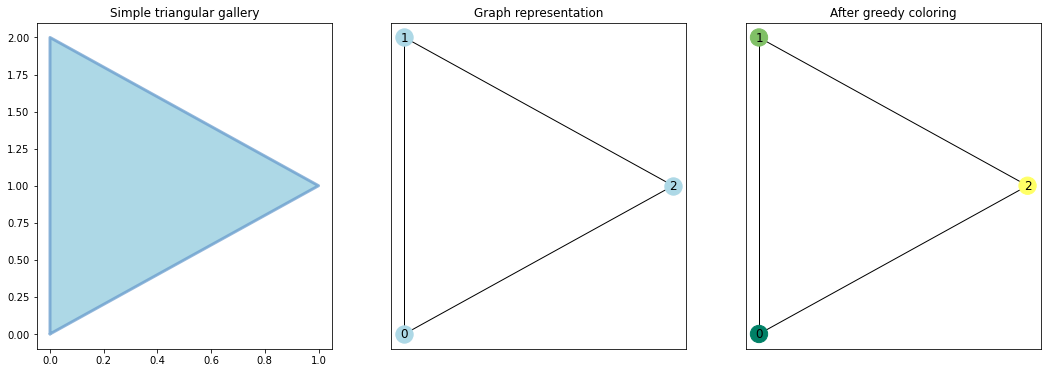

In [4]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,6))

ax[0].set_title('Simple triangular gallery')
ax[1].set_title('Graph representation')
ax[2].set_title('After greedy coloring')

gallery_patch = patches.Polygon(gallery_poly.exterior.coords, color="lightBlue")
ax[0].add_patch(gallery_patch)

ax[0].plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
nx.draw_networkx(G, pos=pos, edgelist=G.edges(), ax=ax[1], node_color="lightBlue")
nx.draw_networkx(G, pos=pos, edgelist=G.edges(), ax=ax[2], node_color=cgroups, cmap=plt.cm.summer)

#plt.savefig("Figure_11-1.svg", format="svg")
#plt.savefig("Figure_11-1.png")
plt.show()

The next cell applies the greedy coloring solution using a value range cval in the scatter plot. Color value ranges are a great way to automatically spread the colors out relative to the number of vertices to be colored.

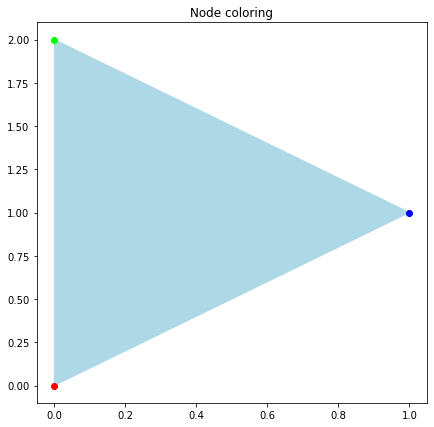

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

ax.set_title('Node coloring')
gallery_patch = patches.Polygon(gallery_poly.exterior.coords, color="lightBlue")
ax.add_patch(gallery_patch)
for k in G.nodes:
    x, y = G.nodes[k]["coords"]
    cval = G.nodes[k]["color"]
    ax.scatter(x, y, color=cval, zorder=3)
ax.plot(x, y, color="teal", alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

plt.show()

# The Boomerang gallery
The following code creates the first real example gallery, which I call the boomerang gallery. The shape of the gallery was chosen to highlight some of the challenges with the theoretical approach. The code also uses the Polygon to create a graph representation, using the same process you just saw.

In [6]:
gallery_poly2 = Polygon(
    [
    (0, 0), (0, 2), (0.55, 1.55), (1.4,0.33),
    (1, 0.33), (0.45, 1.22), (0.25, 1.29)
    ]
)

G = nx.Graph()
gallery_coords = gallery_poly2.exterior.coords[0:-1]
G.add_node(0, coords= gallery_coords[0])
pos = [list(gallery_coords[0])]
for i in range(1,len(gallery_coords)):
    p = gallery_coords[i]
    pos.append(p)
    G.add_edge(i-1, i)
    G.nodes[i]["coords"] = p
    # close the shape edges
    if i == len(gallery_coords)-1:
        G.add_edge(i, 0)

The next code cell generates a 2-column plot to display both representations. One nice feature of the NetworkX library is that it is aware of MatPlotLib.

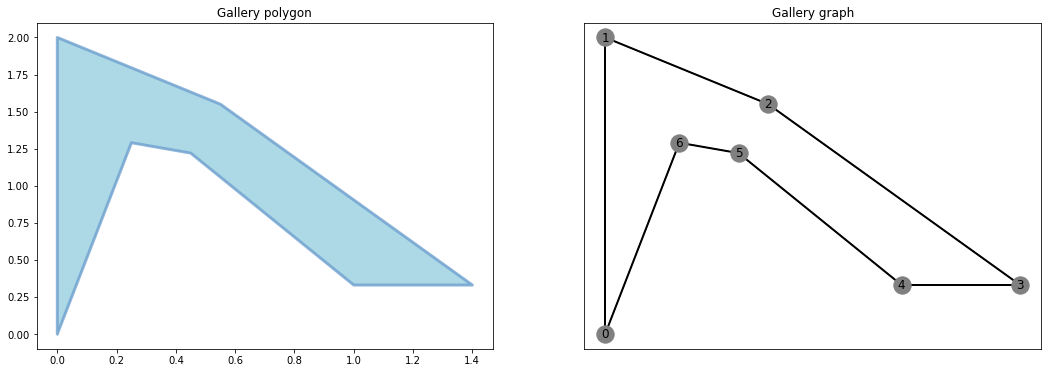

In [7]:
x, y = gallery_poly2.exterior.xy
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].set_title('Gallery polygon')
ax[1].set_title('Gallery graph')


gallery_patch = patches.Polygon(gallery_poly2.exterior.coords, color="lightBlue")
ax[0].add_patch(gallery_patch)
ax[0].plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
nx.draw_networkx(G, pos=pos, edgelist=G.edges(), ax=ax[1], node_color="gray")
nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), ax=ax[1], width=2)
#plt.savefig("Figure_11-3.svg", format="svg")
#plt.savefig("Figure_11-3.png")
plt.show()

## Tessellation with Triangle
The following cell performs the first tessellation using the Triangle wrapper library which wraps a very powerful analysis tool also called Triangle. The features of the underlying tool make it a more logical choice than the shapely version of the function  for the tessellation tasks here, but that doesn't mean we are going to abandon shapely altogether. We still need it to deal with the geometric representation before and after the tessellation function is applied. The final line of the code converts the resulting mesh back into shapely data by casting it into a list of Polygons. The text covers the settings and structure in more detail.

In [8]:
tri_dict = {
    "vertices": gallery_poly2.exterior.coords[:-1],
    "segments": list(G.edges())
}
triangulated = tr.triangulate(tri_dict, "pe")
triangles = [Polygon([G.nodes[p]["coords"] for p in t]) for t in triangulated["triangles"]]

The next cell updates the graph representation to match the tessellation result using the edge list included in the result. The code simultaneously creates another 2-column figure to display both representations side-by-side. This is the code example used in the text (without the display code) because it is more concise than the method after it.

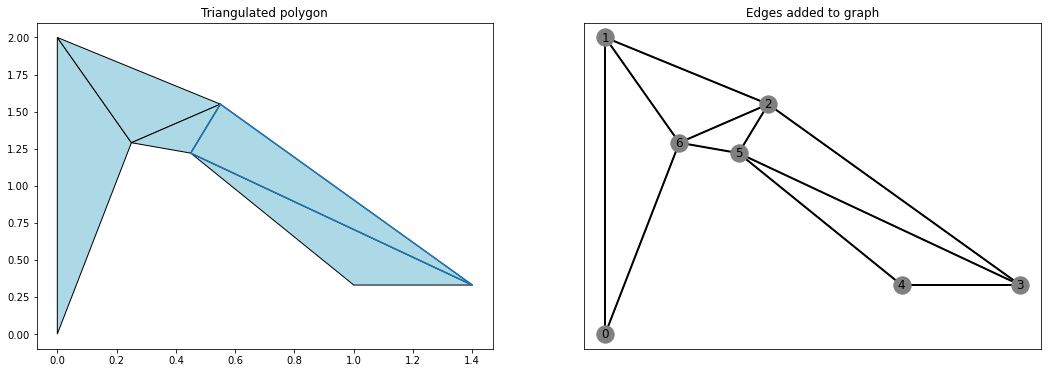

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].set_title('Triangulated polygon')
ax[1].set_title('Edges added to graph')


for t in triangles:
    if not gallery_poly2.contains(t):
        continue
    x, y = t.exterior.xy
    tri_patch = patches.Polygon(t.exterior.coords, facecolor="lightBlue", edgecolor="black")
    ax[0].add_patch(tri_patch)
ax[0].plot(x, y)

G2 = G.copy()
for e in triangulated["edges"]:
    if list(e) not in list(G2.edges()):
        G2.add_edge(e[0], e[1])

nx.draw_networkx(G2, pos=pos, ax=ax[1], node_color="gray")
nx.draw_networkx_edges(G2, pos=pos, edgelist=G2.edges(), ax=ax[1], width=2)
#plt.savefig("Figure_11-4.svg", format="svg")
#plt.savefig("Figure_11-4.png")
plt.show()

You can also update the graph using the triangles list but as you can see the code is longer and less elegant looking. You could potentially shorten it by nesting a loop over the points in each triangle rather than listing the three edges explicitly but while writing this I found that method to be even harder to troubleshoot than explicitly listing the edges.

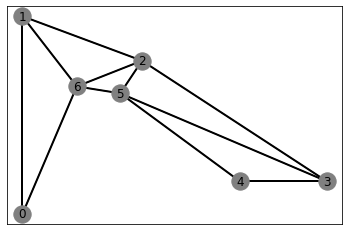

In [10]:
G2 = G.copy()
for t in triangulated["triangles"]:
    if (t[0], t[1]) not in list(G2.edges):
        G2.add_edge(t[0], t[1])
    if (t[1], t[2]) not in list(G2.edges):
        G2.add_edge(t[1], t[2])
    if (t[2], t[0]) not in list(G2.edges):
        G2.add_edge(t[2], t[0])
nx.draw_networkx(G2, pos=pos, node_color="gray")
nx.draw_networkx_edges(G2, pos=pos, edgelist=G2.edges(), width=2)
plt.show()

## Greedy coloring 
The next cell performs the greedy coloring portion of the algorithm. According to wikipedia 
<blockquote>"In the study of graph coloring problems in mathematics and computer science, a greedy coloring or sequential coloring[1] is a coloring of the vertices of a graph formed by a greedy algorithm that considers the vertices of the graph in sequence and assigns each vertex its first available color. Greedy colorings can be found in linear time, but they do not in general use the minimum number of colors possible."</blockquote>
The assigned color groups represent the different groups of guard positions available. Which intuitively means, if there are multiple possible solutions, you will get the first one the algorithm finds that works. Not necessarily the most optimal. The trade-off here is speed for accuracy. For solving the strictly theoretical version of the AGP this form of coloring solution isn't guaranteed to find the optimal number of guards. Fortunately we are interested in real applications so "good and fast" beats "perfect and slow" 8 out of 10 times. 

In [11]:
gallery_coloring = greedy_color(G2)
gallery_coloring

{2: 0, 5: 1, 6: 2, 1: 1, 3: 2, 0: 0, 4: 0}

The next cell creates the two solution graphs presented in the chapter. It starts by iterating over every node in the solution and assigning the group indicated as a node attribute on the graph representation. It then collects all of these groups into a list called cgroups which is necessary to use the built-in color map summer.

The left graph is built using the built draw_networkx function along with the updated edges and the color groups previously defined in cgrpoups The right-hand plot is built by iterating over each group and assigning a different (this time from the group_color function) and symbol (using the group_symbol function). Each group is plotted using the draw_networkx_nodes function which doesn't plot the edges of the graph, only the nodes. Finally the edges are added to the second plot from the original graph which ignores the edges added to the copy.

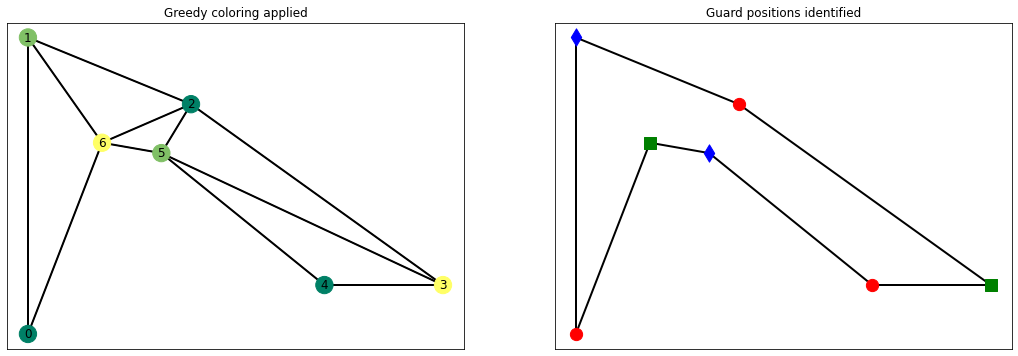

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].set_title('Greedy coloring applied')
ax[1].set_title('Guard positions identified')

for k in gallery_coloring.keys():
    v = gallery_coloring[k]
    G2.nodes[k]["color"] = color_list[v].rgb
    G2.nodes[k]["group"] = v
cgroups = [G2.nodes[k]["group"] for k in G2.nodes]
g_count = count_groups(gallery_coloring)

nx.draw_networkx(G, pos=pos, edgelist=G2.edges(), node_color=cgroups, cmap=plt.cm.summer, ax=ax[0])

for i in range(g_count):
    #Create a subgraph for each group which can then be used to differentiate them in displays
    group = G2.subgraph([n for n in list(G2.nodes()) if G2.nodes[n]["group"] == i])
    sym = group_symbol(i)
    clr = group_color(i)
    nx.draw_networkx_nodes(group, pos=pos, node_shape=sym, node_color=clr, node_size=150)

#add the thicker edges so they show in the published version better
nx.draw_networkx_edges(G2, pos=pos, edgelist=G2.edges(), width=2, ax=ax[0])
nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), width=2, ax=ax[1])

#plt.savefig("Figure_11-5.svg", format="svg")
#plt.savefig("Figure_11-5.png")
plt.show()

## Gallery Scale
These shapes and graphs don't mean anything without some context of physical space. Does the boomerang represent a small office space or a large metropolitan museum? For the shapes to make sense you need to start by creating them by scaling the original design. If you start from a floor plan you can usually find the scale on the document itself (such as 1"=12" meaning 1 inch on the diagram is equal to 12 inches of physical space). In the chapter example I use the scale of one graph unit being equal to 300 meters. To determine the area of the gallery, multiply the shapely area by the scaling factor. You need to remember to apply scaling to areas and distances before outputting them to users otherwise you will get nonsensical outputs that are fractions of graph units, rather than the expected physical distances.

In [13]:
print("Gallery area: %.3fm2" % (gallery_poly2.area * 300))

Gallery area: 241.425m2


## Constrained Delaunay Triangulation
The power of the Triangle tool comes from its flexibility in allowing you to apply one or more constraints on the tessellation result such as maximum area or angle for triangles in the mesh as well as the number of points that can be added. The next cell performs a constrained triangulation on the boomerang gallery, which restricts the maximum area of triangles in the mesh to 0.1 graph units (which is equal to about 30m2 of physical space given the scaling factor mentioned a moment ago. The code updates another copy of the original graph and solves the greedy coloring to complete the entire solution process (less the creation of the polygon and graph representations) in one condensed, efficient, code block. This shows how compact the algorithm can be once you have the gallery converted.

In [14]:
cover_tri_dict = {
    "vertices": gallery_poly2.exterior.coords[:-1],
    "segments": list(G.edges())
}
triangulated = tr.triangulate(cover_tri_dict, "pea0.1")
G3 = G.copy()
pos = list(triangulated["vertices"])
for i in range(len(triangulated["vertices"])):
    if i not in G3.nodes:
        G3.add_node(i, coords=triangulated["vertices"][i])
for e in triangulated["edges"]:
    if list(e) not in list(G3.edges()):
        G3.add_edge(e[0], e[1])
gallery_coloring = greedy_color(G3)
gallery_coloring

{2: 0,
 6: 1,
 5: 2,
 11: 0,
 12: 0,
 0: 2,
 1: 1,
 4: 1,
 8: 1,
 9: 2,
 10: 2,
 3: 3,
 7: 3,
 13: 3}

The following cell simply plots the result from the previous cell. The initial plot doesn't have thick edges and they didn't show well in the chapter preview so I added a second layer of edges with a slightly heavier weight so they appeared. 

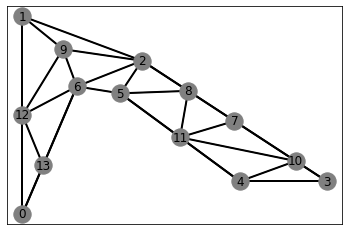

In [15]:
nx.draw_networkx(G3, pos=pos, node_color="gray")
nx.draw_networkx_edges(G3, pos=pos, edgelist=G3.edges(), width=2)
plt.show()

The code in the next cell should look familiar since it simply repeats the process of assigning groups and colors similar to the code in cell 8 above. I plot the mesh result and the group assignment on a 2-column plot.

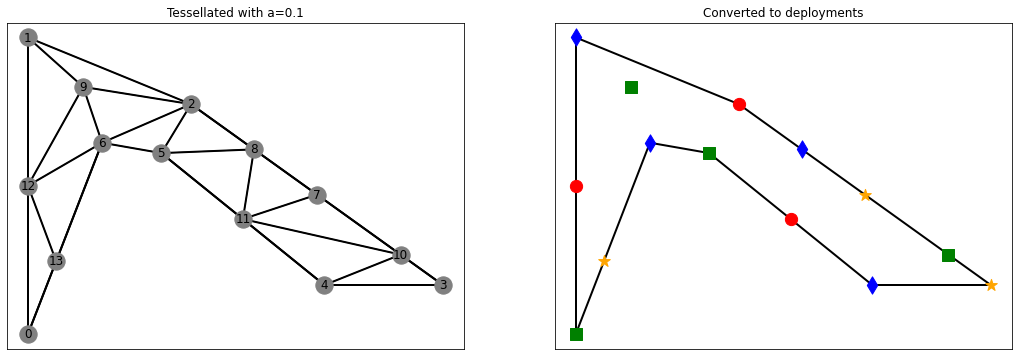

In [16]:
for k in gallery_coloring.keys():
    v = gallery_coloring[k]
    G3.nodes[k]["group"] = v

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

cgroups = [G2.nodes[k]["group"] for k in G2.nodes]
g_count = count_groups(gallery_coloring)

nx.draw_networkx(G3, pos=pos, edgelist=G3.edges(), node_color="gray", ax=ax[0])

for i in range(g_count):
    #Create a subgraph for each group which can then be used to differentiate them in displays
    group = G3.subgraph([n for n in list(G3.nodes()) if G3.nodes[n]["group"] == i])
    sym = group_symbol(i)
    clr = group_color(i)
    nx.draw_networkx_nodes(group, pos=pos, node_shape=sym, node_color=clr, node_size=150)

nx.draw_networkx_edges(G3, pos=pos, edgelist=G3.edges(), width=2, ax=ax[0])
nx.draw_networkx_edges(G3, pos=pos, edgelist=G.edges(), width=2, ax=ax[1])

#plt.savefig("Figure_11-6.svg", format="svg")
#plt.savefig("Figure_11-6.png")
ax[0].set_title("Tessellated with a=0.1")
ax[1].set_title("Converted to deployments")
plt.show()

The next plot shows the positions of the selected deployment using the group to create a subgraph from the copy G3. The nodes represent the position to place the 3 guards so they can (almost) cover all the triangles. Here we see a problem resulting from the greedy coloring approach. The yellow star at node 3 could also have been a circle. If that solution were presented the circle deployment would actually cover all the triangles, but it would have 4 positions instead of 3 and the star deployment would only have two (which would actually match the theoretical maximum for this gallery without the area constraint applied).  

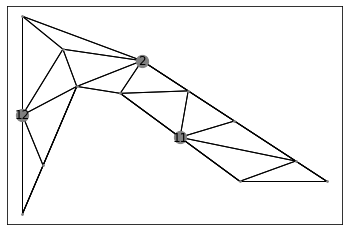

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1)
not_selected = G3.subgraph([n for n in list(G3.nodes()) if G3.nodes[n]["group"] != 0])
group_0 = G3.subgraph([n for n in list(G3.nodes()) if G3.nodes[n]["group"] == 0])
nx.draw_networkx(
    group_0, pos=pos, node_shape='o', node_color="gray",
    node_size=150, edgelist=G3.edges(), ax=ax)
nx.draw_networkx(
    not_selected, pos=pos, node_shape='o', node_color="gray",
    node_size=3, edgelist=G3.edges(), ax=ax, with_labels=False)
plt.show()

## creating AoR maps
To address the problem above I came up with a simple heuristic of assigning the to the closest guard. The code in the following cell holds the prototype code for the assign_triangles help above. I didn't switch this code out because it also builds a side-by-side comparison of the before and after result of assigning the triangles. The code creates two lists of polygon patches for display purposes. During the assignment each triangle is assigned the color of the associated guard. If no guard is found the tri_patches_0 list gets a black triangle, while the tri_patches_1 list gets a triangle which has the color result from assigning it to the closest guard position.

The closest guard node is measured using closest point straight-line distance from the triangle to each guard node using shapely's distance function. The chapter text discusses some flaws with the heuristic approach and some potential improvements.

In [18]:
triangles = {2:[], 11:[], 12:[]}
tri_patches_0 = [] # patches for the left side plot shows unassigned triangles
tri_patches_1 = []
for i in range(len(triangulated["triangles"])):
    t = triangulated["triangles"][i]
    t_poly = Polygon([G3.nodes[p]["coords"] for p in t])
    
    guard_colors = {
        2: "#696868",
        11:"#a3a2a2",
        12:"#4f4e4e"
    }
    # if triangle touches a guard directly at any point
    if t[0] in list(guard_colors.keys()):
        triangles[t[0]].append(t_poly)
        clr0 = guard_colors[t[0]]
        clr1 = guard_colors[t[0]]
    elif t[1] in list(guard_colors.keys()):
        triangles[t[1]].append(t_poly)
        clr0 = guard_colors[t[1]]
        clr1 = guard_colors[t[1]]
    elif t[2] in list(guard_colors.keys()):
        triangles[t[2]].append(t_poly)
        clr0 = guard_colors[t[2]]
        clr1 = guard_colors[t[2]]
    else:
        print("uncovered triangle", t)
        g1 = G3.nodes[2]["coords"]
        g2 = G3.nodes[11]["coords"]
        g3 = G3.nodes[12]["coords"]
        dists = {
            2: t_poly.distance(Point(g1)),
            11: t_poly.distance(Point(g2)),
            12: t_poly.distance(Point(g3))
        }
        close = min(dists, key=dists.get)
        print("closest: %d" % close)
        triangles[close].append(t_poly)
        clr1 = guard_colors[close] # right plot color triangles by closest guard
        clr0 = "#000000" # left plot color uncovered triangles black

    tri_patch = patches.Polygon(t_poly.exterior.coords, facecolor=clr0, edgecolor="black")
    tri_patches_0.append(tri_patch)
    tri_patch1 = patches.Polygon(t_poly.exterior.coords, facecolor=clr1, edgecolor="black")
    tri_patches_1.append(tri_patch1)

uncovered triangle [ 4  3 10]
closest: 11


The following cell creates the display from the previously generated two lists of polygon patches.

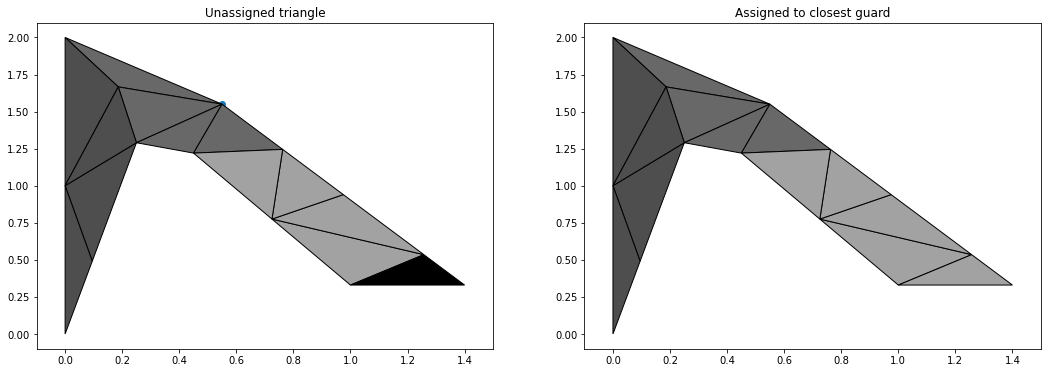

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))
x = [G.nodes[n]["coords"][0] for n in G.nodes if n in [2, 11, 12]]
y = [G.nodes[n]["coords"][1] for n in G.nodes if n in [2, 11, 12]]
ax[0].scatter(x, y)
for p in tri_patches_0:
    ax[0].add_patch(p)
ax[0].set_ylim(-0.1, 2.1)
ax[0].set_xlim(-0.1, 1.5)
for p in tri_patches_1:
    ax[1].add_patch(p)
ax[1].set_ylim(-0.1, 2.1)
ax[1].set_xlim(-0.1, 1.5)
ax[0].set_title("Unassigned triangle")
ax[1].set_title("Assigned to closest guard")

#plt.savefig("Figure_11-7.svg", format="svg")
#plt.savefig("Figure_11-7.png")
plt.show()

The code in next cell shows the process for summing the area assigned to each guard position. Remember you need to adjust for the scaling factor as I mentioned previously. It is a fairly straight forward process of looking up all the triangles assigned to a given guard(created in the previous cell as the triangles dictionary) and summing the individual areas.

In [21]:
for k in triangles.keys():
    area = sum([(t.area * 300) for t in triangles[k]])
    print("Position %d covers %.2fm2" % (k ,area))

Position 2 covers 60.41m2
Position 11 covers 98.68m2
Position 12 covers 82.34m2


The next cell creates an AoR map for all the potential deployments from the previous coloring solution. You can see in the square deployment the result of the heuristic failing to assign a triangle to the proper logical guard. The code and the image plots didn't make it into the chapter text due to space considerations, but I have included it here so you can adapt it if you choose.

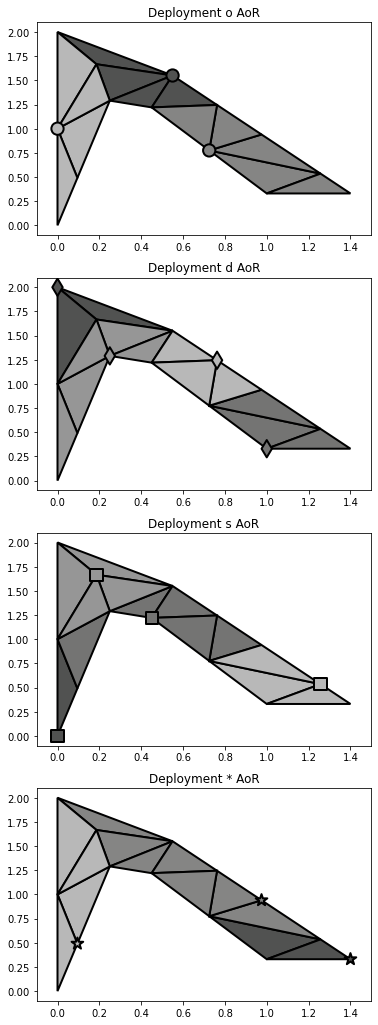

In [21]:
g_count = count_groups(gallery_coloring)
fig, ax = plt.subplots(ncols=1, nrows=g_count, figsize=(6,18))
red = Color("#515251")
blue = Color("#b8b8b8")

for i in range(g_count):
    assigned = assign_triangles(G3, triangulated, i)
    sym = group_symbol(i)
    color_list = [c.rgb for c in list(red.range_to(blue, len(assigned.keys())))]
    x = [G3.nodes[n]["coords"][0] for n in G3.nodes if n in list(assigned.keys())]
    y = [G3.nodes[n]["coords"][1] for n in G3.nodes if n in list(assigned.keys())]
    ax[i].scatter(x, y, zorder=10, s=150, marker=sym, c=color_list, edgecolor="black", linewidths=2)
    for j in range(len(list(assigned.keys()))):
        k = list(assigned.keys())[j]
        for p in assigned[k]:
            tri_patch = patches.Polygon(p.exterior.coords, facecolor=color_list[j], edgecolor="black", linewidth=2)
            ax[i].add_patch(tri_patch)
    ax[i].set_ylim(-0.1, 2.1)
    ax[i].set_xlim(-0.1, 1.5)
    ax[i].set_title("Deployment %s AoR" % sym)

plt.show()

The next cell is just for fun as well. It creates an even smaller area constraint of 0.02 which adds lots of Steiner points. For our current scale factor that means the physical area for triangles would be about 6m2 which is typically very small for zones. For a very high security establishment, such as a casino fro example, you may end up using relatively small zones like this to ensure tight overlapping coverages between human guards and sensors For example you may choose the star deployment for human guards and the square deployment for cameras. The display is the same as the previous examples

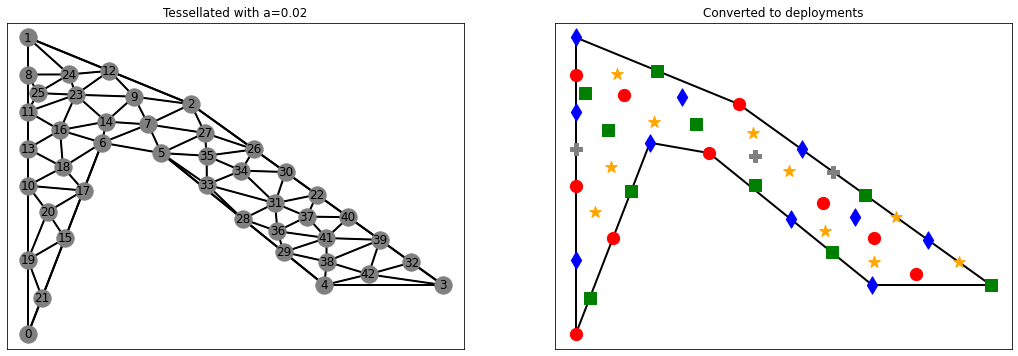

In [22]:
cover_tri_dict = {
    "vertices": gallery_poly2.exterior.coords[:-1],
    "segments": list(G.edges())
}
triangulated = tr.triangulate(cover_tri_dict, "pea0.02")
G4 = G.copy()
pos = list(triangulated["vertices"])
for i in range(len(triangulated["vertices"])):
    if i not in G4.nodes:
        G4.add_node(i, coords=triangulated["vertices"][i])
for e in triangulated["edges"]:
    if list(e) not in list(G4.edges()):
        G4.add_edge(e[0], e[1])
gallery_coloring = greedy_color(G4)

for k in gallery_coloring.keys():
    v = gallery_coloring[k]
    G4.nodes[k]["group"] = v

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

cgroups = [G4.nodes[k]["group"] for k in G4.nodes]
g_count = count_groups(gallery_coloring)

nx.draw_networkx(G4, pos=pos, edgelist=G4.edges(), node_color="gray", ax=ax[0])
sym_group = {}
for i in range(g_count):
    #Create a subgraph for each group which can then be used to differentiate them in displays
    group = G4.subgraph([n for n in list(G4.nodes()) if G4.nodes[n]["group"] == i])
    sym = group_symbol(i)
    clr = group_color(i)
    sym_group[sym] = i
    nx.draw_networkx_nodes(group, pos=pos, node_shape=sym, node_color=clr, node_size=150)

nx.draw_networkx_edges(G4, pos=pos, edgelist=G4.edges(), width=2, ax=ax[0])
nx.draw_networkx_edges(G4, pos=pos, edgelist=G.edges(), width=2, ax=ax[1])

ax[0].set_title("Tessellated with a=0.02")
ax[1].set_title("Converted to deployments")
plt.show()

## Dealing with complex polygons
I am going to switch the boomerang example out for a square example now to show how to deal with inaccessible areas, or holes, in floor plans using complex polygons. The code creates a larger square gallery which contains a smaller square hole in its center.

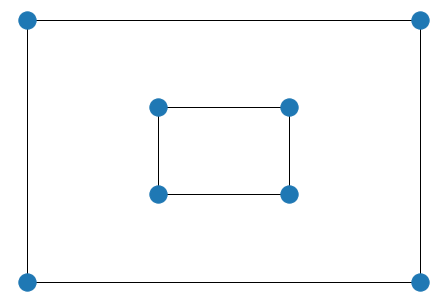

In [23]:
ext_3 = [(0.0, 0.0), (0.0, 3.0), (3.0, 3.0), (3.0, 0.0)]
int_3 = [(1.0, 1.0), (1.0, 2.0), (2.0, 2.0), (2.0, 1.0)]
gallery_3 = Polygon(ext_3, holes=[int_3])
hole_p = Polygon(int_3).representative_point()
G = nx.Graph()
verts = ext_3 + int_3
G.add_node(0, coords=(0.0, 0.0))
G.add_node(1, coords=(0.0, 3.0))
G.add_node(2, coords=(3.0, 3.0))
G.add_node(3, coords=(3.0, 0.0))
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 0)
G.add_node(4, coords=(1.0, 1.0))
G.add_node(5, coords=(1.0, 2.0))
G.add_node(6, coords=(2.0, 2.0))
G.add_node(7, coords=(2.0, 1.0))

G.add_edge(4, 5)
G.add_edge(5, 6)
G.add_edge(6, 7)
G.add_edge(7, 4)

pos = [G.nodes[n]["coords"] for n in G.nodes()]
nx.draw(G, pos=pos)

Now we perform the tessellation on the square example. The only change from previous tessellations is the addition of the holes key which holds a list of points. See the text for more details on how the holes are defined.

In [24]:
hp1 = [list(v)[0] for v in list(hole_p.xy)]
segs = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4)]
sq_tri_dict = {
    "vertices": verts,
    "segments": segs,
    "holes":[hp1]
}
triangulated = tr.triangulate(sq_tri_dict, "pe")

The next cell builds a 5-column graph to show the entire process in one image. The process of solving the coloring is the same as previously seen. This was one of the most complex figures to develop for the whole book.

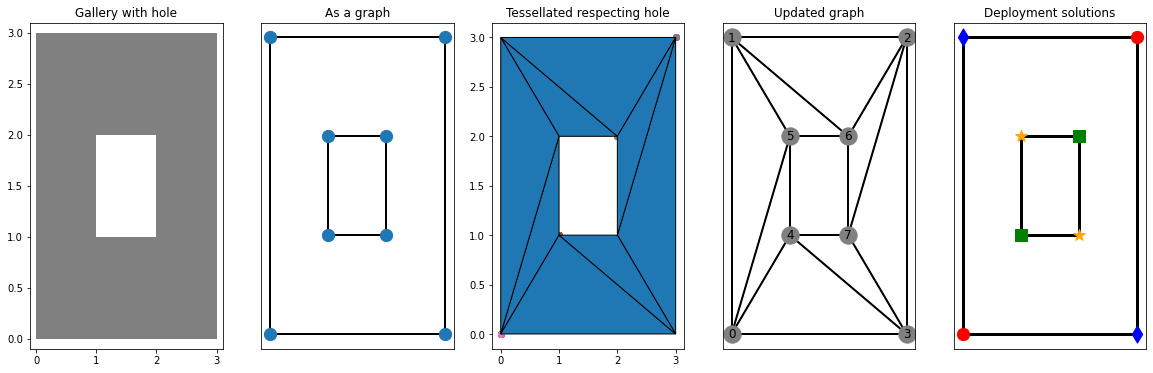

In [25]:
G2 = G.copy()

for i in range(len(triangulated["vertices"])):
    if i not in G2.nodes:
        G2.add_node(i, coords=pos[i])
for e in triangulated["edges"]:
    if list(e) not in list(G2.edges()):
        G2.add_edge(e[0], e[1])
gallery_coloring = greedy_color(G2)

for k in gallery_coloring.keys():
    v = gallery_coloring[k]
    G2.nodes[k]["group"] = v

fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,6))
ax[0].set_title("Gallery with hole")
ax[1].set_title("As a graph")
ax[2].set_title("Tessellated respecting hole")
ax[3].set_title("Updated graph")
ax[4].set_title("Deployment solutions")
sq_patch = patches.Polygon(ext_3, facecolor='gray')
h_patch = patches.Polygon(int_3, facecolor='white')
ax[0].add_patch(sq_patch)
ax[0].add_patch(h_patch)
ax[0].set_ylim(-0.1, 3.1)
ax[0].set_xlim(-0.1, 3.1)
nx.draw_networkx_nodes(G, pos=pos, node_size=150, ax=ax[1])
sym_group = {}
for i in range(g_count):
    #Create a subgraph for each group which can then be used to differentiate them in displays
    group = G2.subgraph([n for n in list(G2.nodes()) if G2.nodes[n]["group"] == i])
    sym = group_symbol(i)
    clr = group_color(i)
    sym_group[sym] = i
    nx.draw_networkx_nodes(group, pos=pos, node_shape=sym, node_color=clr, node_size=150, ax=ax[4])
nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), width=2, ax=ax[1])
nx.draw_networkx_edges(G2, pos=pos, edgelist=G2.edges(), width=2, ax=ax[3])
nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), width=3, ax=ax[4])
g_count = count_groups(gallery_coloring)
pos = [G2.nodes[n]["coords"] for n in G2.nodes()]
nx.draw_networkx(G2, pos=pos, edgelist=G2.edges(), node_color="gray", ax=ax[3])
for i in range(len(triangulated["triangles"])):
    t = triangulated["triangles"][i]
    t_poly = Polygon([G2.nodes[p]["coords"] for p in t])
    t_patch = patches.Polygon(t_poly.exterior.coords, edgecolor="black")
    ax[2].add_patch(t_patch)
    x = [G2.nodes[p]["coords"][0] for p in t]
    y = [G2.nodes[p]["coords"][0] for p in t]
    ax[2].scatter(x, y)
    
#plt.savefig("Figure_11-8.svg", format="svg")
#plt.savefig("Figure_11-8.png")
plt.show()

## Field of View

The code for displaying the field of view diagram is not my favorite. I took some shortcuts to make it work with the same libraries already used. You can likely find better ways of computing these in game graphics tutorials for libraries such as PyGame.

[232, 219, 206, 193, 180, 167, 154, 141]
[186, 173, 160, 147, 134, 121, 108, 95]
[97, 84, 71, 58, 45, 32, 19, 6]
[403, 390, 377, 364, 351, 338, 325, 312]


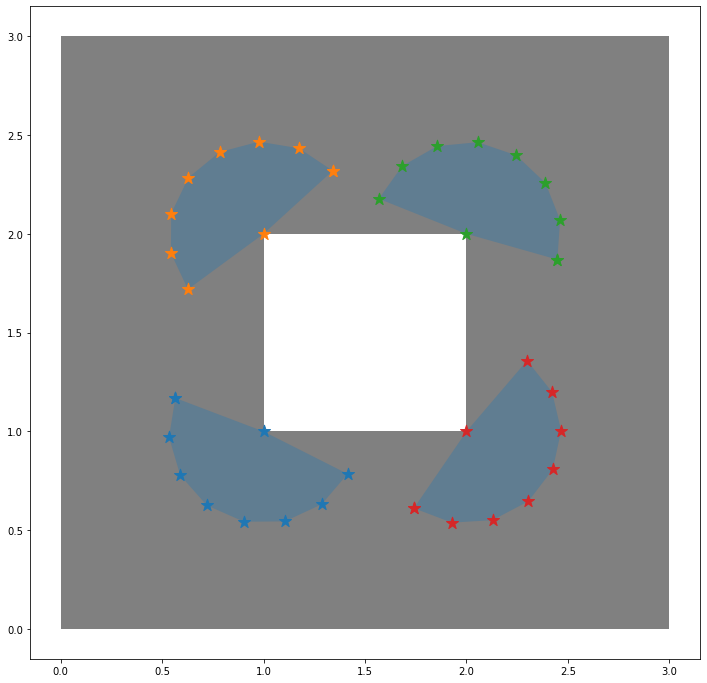

In [26]:
# Add the facing angle as node attributes for the 4 camera locations
G2.nodes[4]["angle"] = 180
G2.nodes[5]["angle"] = 134
G2.nodes[6]["angle"] = 45
G2.nodes[7]["angle"] = 351

sym = '*'
g_id = sym_group[sym]
group = G2.subgraph([4,5,6,7])
fov = 104
night_range = float(7 * (1/300)) # figure out the scaled night ange
day_range = night_range * 20 # Then use that to estimate the day range

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
sq_patch = patches.Polygon(ext_3, facecolor='gray')
h_patch = patches.Polygon(int_3, facecolor='white')
ax.add_patch(sq_patch) # Add the gallery patch
ax.add_patch(h_patch) # Add the hole patch
view_polys = []
view_patches = []
for g,d in group.nodes(data=True):
    p = d["coords"]
    angle = d["angle"]
    # create the lists of view points and angles
    view_points, angles = create_fov_coords(p, angle, fov, day_range, 8)
    view_poly = Polygon(view_points) # Convert result top a polygon
    view_polys.append(view_poly)
    # Collect the data for the scatter plot
    x = [n[0] for n in view_points]
    y = [n[1] for n in view_points]
    # Create the patch representing the FoV
    view_patch = patches.Polygon(view_points, alpha=0.33)
    ax.scatter(x, y, s=160, zorder=10, marker=sym) # Plot the scatter data
    ax.add_patch(view_patch) # add the FoV patch

#plt.savefig("Figure_11-12.svg", format="svg")
#plt.savefig("Figure_11-12.png")
plt.show()

Once you have the FoV polygons defined you can compare their total area to the total area of the gallery to get an approximate coverage percentage

In [27]:
print(gallery_3.area)
covered = sum([v.area for v in view_polys])
print(covered)
cover_rat = covered / (gallery_3.area - covered)
print(cover_rat * 100)

8.0
1.281042610058114
19.06609218828807


# Customizing deployments with regions
The code in the next few cells covers the process of defining regions and refining meshes in Triangle. The code in the next cell adds a set of 4 regions to the square example. The chapter covers the definition of the regions and how to apply them. One interesting note here, I change to the compare function for displaying the region data. The wrapper library has code which works directly with PyPlot to automate the display of the regions

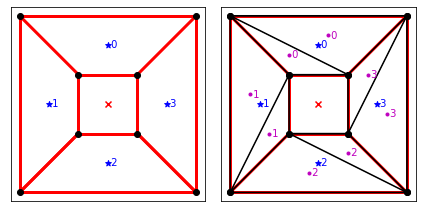

In [28]:
regions = [
        [(1,5),(5,6),(6,2),(2,1)],
        [(1,5),(5,4),(4,0),(0,1)],
        [(0,4),(4,7),(7,3),(3,0)],
        [(3,7),(7,6),(6,2),(2,3)]
    ]
segs = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4)]
regs = []
for i in range(len(regions)):
    r = regions[i]
    for s in r:
        # Add the logical regional boundaries 
        if s not in segs:
            segs.append(s)
    r_coords = []
    for edge in r:
        # Collect the first point from every edge into a coordinate list
        p1 = G2.nodes[edge[0]]["coords"]
        r_coords.append(p1)
    # Convert region into a Polygon
    r_poly = Polygon(r_coords)
    r_point = r_poly.representative_point() # Calculate a representative point
    p = [list(v)[0] for v in list(r_point.xy)]
    regs.append([p[0], p[1], i, 0]) # X, Y, Region, Attribute
    
sq_tri_dict = {
    "vertices": verts,
    "segments": segs,
    "holes":[hp1],
    "regions":regs
}
triangulated = tr.triangulate(sq_tri_dict, "peA")
tr.compare(plt, sq_tri_dict, triangulated)
#plt.savefig("Figure_11-9.svg", format="svg")
#plt.savefig("Figure_11-9.png")
plt.show()

The resulting region is assigned to each triangle under the triangle_attributes key in the resulting dictionary.

In [29]:
triangulated

{'vertices': array([[0., 0.],
        [0., 3.],
        [3., 3.],
        [3., 0.],
        [1., 1.],
        [1., 2.],
        [2., 2.],
        [2., 1.]]),
 'vertex_markers': array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=int32),
 'triangles': array([[0, 4, 5],
        [4, 0, 3],
        [1, 5, 6],
        [5, 1, 0],
        [7, 3, 2],
        [3, 7, 4],
        [6, 2, 1],
        [2, 6, 7]], dtype=int32),
 'triangle_attributes': array([[1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
        [0.],
        [3.]]),
 'segments': array([[0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [5, 1],
        [6, 2],
        [0, 4],
        [3, 7]], dtype=int32),
 'segment_markers': array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
       

## Saving meshes
One feature the triangle wrapper didn't expose was the ability to save data files. The udnerlying Triangle program works with a custom flat file format detailed on the project's site. I took the description of the file format and used that to produce my own DataSaver class. Also, because it's mine, I can do all the fun stuff I want like adding in the logic to assign maximum areas based on regional assignments.

In [30]:
from filemanager import DataSaver
saver = DataSaver(triangulated, "square")
saver.set_region_areas([-1,0.1,-1,0.3])
saver.save_project()

Because I wrote my own saver I wanted to make sure my results upon reloading and refining matched the results from directly calling the underlying Triangle program. The next file was created by calling the underlying program directly from the command line with the project files previously created. The refined mesh was saved for comparison. Ideally there will be no difference between calling the library directly and using the wrapper.

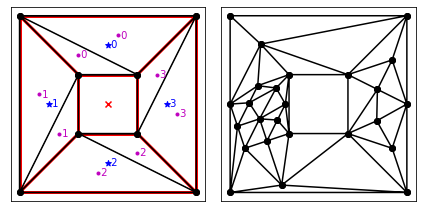

In [31]:
reload = tr.load(".", "square_1.1")
tr.compare(plt, triangulated, reload)
#plt.savefig("Figure_11-10.svg", format="svg")
#plt.savefig("Figure_11-10.png")
plt.show()

Now I am going to create another duplicate project save and call the refinement function using the Triangle wrapper. The result of the refinement step should be identical to the one previously shown, proving the save code and the load function are both operating as expected.

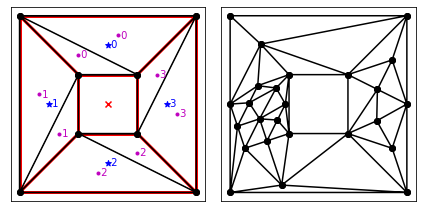

In [32]:
# Save the Triangle files
saver = DataSaver(triangulated, "square", 2)
saver.set_region_areas([-1,0.1,-1,0.3])
saver.save_project()
# Reload the saved data
reload2 = tr.load(".", "square_2")
# Perform the refinement tessellation
refined = tr.triangulate(reload2, "ra")

tr.compare(plt, triangulated, refined)
#plt.savefig("Figure_11-10.svg", format="svg")
#plt.savefig("Figure_11-10.png")
plt.show()

Finally I save another copy of the square project with the version number 3. no regions were included in the last refinement so there is no need to set the region areas.

In [33]:
saver = DataSaver(refined, "square", 3)
saver.save_project()

# Limiting deployments
The next portion of the notebook deals with limiting the number of Steiner points added to the mesh. The next cell performs the same tessellation as the previous cell, but with the additional constraint of only being allowed to add 3 points to the mesh.

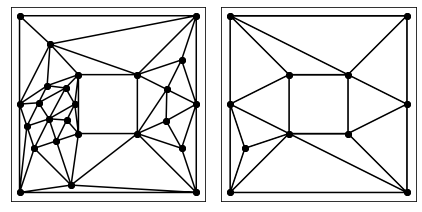

In [34]:
refined2 = tr.triangulate(reload2, "reaS3")

tr.compare(plt, refined, refined2)
#plt.savefig("Figure_11-11 .svg", format="svg")
#plt.savefig("Figure_11-11.png")
plt.show()